# Milestone project 2: Buldozer Price Regression model

In this notbook we're going to go through an example machine learning project with the goal of predicting the sale price of 
buldozers.

## Predcting heart disease using macine learning
This notebook looks into using various Python based librariesin an attempt to build a machine learning model capable of predicting whether or not someone has heard disease based on their medical attributes

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem definition

In a statement,
> How well can we predict the future sale price o a buldozer, given its characteristics and previous examples of how much similar buldozers have been sold for?

## 2. Data

The data was downloaded from the Kaggle competition [Bluebook for Buldozers](https://www.kaggle.com/c/bluebook-for-bulldozers)

The data for this model is split into three parts:

Train.csv is the training set, which contains data through the end of 2011.
Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

## 4. Featrues

This is where you will get different information about the different columns in the dataset

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale
- There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.
- The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

Check out more [here](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

### Parsing dates

When working with timeseries data, we want to enrich the time and date component as much as possible

We can do this by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [2]:
# Importing training and validation sets

df = pd.read_csv("../resources/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"]) # it is a big dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

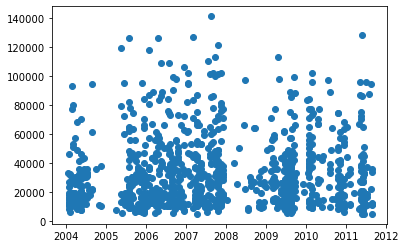

In [5]:
fig, ax = plt.subplots()
ax.scatter(df.loc[:1000, "saledate"], df.loc[:1000, "SalePrice"])

<AxesSubplot:ylabel='Frequency'>

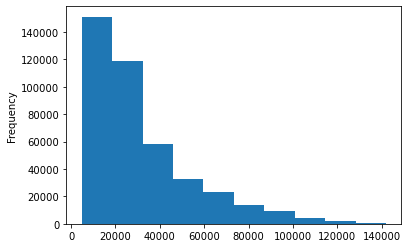

In [6]:
df.SalePrice.plot.hist()

In [7]:
# Sorting the dataframe in date order

df.sort_values(by="saledate", inplace=True, ascending=True)

In [8]:
### Make a copy of the original DataFrame
df_tmp = df.copy()

### Feature Engineering

In [9]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [10]:
# Now we've enriched the dataframe with date time features we'll remove the date column
df_tmp.drop("saledate", inplace=True, axis=1)

## 5. Modelling

We've done enough EDA (we could do more). Now we'll do some modelling.

In [11]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

### Convert strings to categories

One way we can turn all our data into numbers is by turning them into pandas categories. We can check different datatypes compatible with pandas [here](https://pandas.pydata.org/docs/reference/general_utility_functions.html#data-types-related-functionality).

In [12]:
# Find all the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

Thanks to pandas categories we now have a way to access all our data in the form of numbers.

But we still have a lot of null values.

## Filling missing values

In [13]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            df_tmp[label] = content.fillna(content.median()) 

auctioneerID
MachineHoursCurrentMeter


In [14]:
# Turn categorical values into numbers and then fill missing.
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            df_tmp[label + "_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes + 1

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [15]:
%%time

# Fit the model
# model.fit(df_tmp.drop("SalePrice", axis=1), df["SalePrice"])

Wall time: 0 ns


In [16]:
# Splitting the data into train/validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

In [17]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculates Rood Mean Square Log Error between predictions and true labels.
    
    Arguments:
        y_test: The actual true labels
        y_pred: The predictions
    
    Returns:
        The RMSLE
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R2": r2_score(y_train, train_preds),
              "Valid R2": r2_score(y_valid, val_preds)
             }
    return scores


## Testing our model on a subset

In [18]:
# Change max samples values

model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [19]:
%%time
#Cutting down max samples improves the time this needs to run
model.fit(X_train, y_train)

Wall time: 9.39 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [20]:
show_scores(model)

{'Training MAE': 5561.513057924589,
 'Valid MAE': 7155.632784930442,
 'Training RMSLE': 0.2578005599357549,
 'Valid RMSLE': 0.29223097494391737,
 'Training R2': 0.860722898583499,
 'Valid R2': 0.832588403039663}

## Hyperparameter tuning and RandomizedSearchCV

In [21]:
%%time

from sklearn.model_selection import RandomizedSearchCV

rf_grid = { 
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.2, 1, "sqrt", "auto"],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), 
                             param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True
                             )

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 1min 20s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.2, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [22]:
# Evaluate the Randomized Search model.

print(show_scores(rs_model))

print(rs_model.best_params_)

{'Training MAE': 6593.974179121005, 'Valid MAE': 7935.73063592583, 'Training RMSLE': 0.29503497129160866, 'Valid RMSLE': 0.3182291893971808, 'Training R2': 0.8116687355408185, 'Valid R2': 0.7934151544311383}
{'n_estimators': 20, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_samples': 10000, 'max_features': 'auto', 'max_depth': 10}


## Train a model with the best hyperparameters

**Note:** Run with n_iter=100 and run over 2 hours

In [23]:
%%time

ideal_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, min_samples_split=14, max_features=0.5, n_jobs=-1, max_samples=None)

ideal_model.fit(X_train, y_train)


Wall time: 51.8 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [24]:
show_scores(ideal_model)

{'Training MAE': 2956.4635059675816,
 'Valid MAE': 5961.3368083125015,
 'Training RMSLE': 0.14452967992982438,
 'Valid RMSLE': 0.2459267262820982,
 'Training R2': 0.9587937851486718,
 'Valid R2': 0.8818119946014108}

## Make predictions on test data

In [25]:
# import test data

df_test = pd.read_csv("../resources/bluebook-for-bulldozers/Test.csv", low_memory=False, parse_dates=["saledate"])

In [26]:
# format data to the same format as the data that we trained the model with.

def preprocess_data(df):
    """Performs transformations on df and returns the transformed dataframe"""
    
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    
    ## fill numeric values
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                print(label)
                df[label + "_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        ## fill categorical values with category numbers
        else:
            print(label)
            if pd.isnull(content).sum():
                df[label + "_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [27]:
df_test = preprocess_data(df_test)

MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
print(df_test.shape, df_train.shape)

# We can find how the columns differ using sets

set(X_train.columns) - set(df_test.columns)

(12457, 95) (401125, 97)


{'auctioneerID_is_missing'}

In [30]:
df_test["auctioneerID_is_missing"] = True

In [31]:
test_preds = ideal_model.predict(df_test)

C:\Users\cos_9\Anaconda3\envs\machine_learning_env\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


## Feature Importance

Feature importance seeks to figure out which different attributes of the data were the most important to predicting the sales 
price of buldozers

In [32]:
ideal_model.feature_importances_

array([3.24560053e-02, 1.95372700e-02, 4.44794221e-02, 1.65945754e-03,
       3.29371769e-03, 2.04102148e-01, 3.04762891e-03, 1.00065312e-03,
       3.81611876e-02, 5.17707952e-02, 6.77721784e-02, 4.91169749e-03,
       1.83754339e-02, 1.47553126e-01, 4.33506984e-02, 6.03085024e-03,
       1.81222095e-03, 2.43455037e-03, 4.57589745e-03, 6.12946969e-02,
       2.85868915e-04, 6.93309086e-04, 7.97860208e-04, 1.63191465e-04,
       1.02246410e-03, 2.54883376e-05, 1.20468825e-03, 1.23950408e-02,
       3.07857260e-04, 1.18173709e-04, 1.87006212e-03, 2.04623862e-03,
       3.08554723e-03, 2.34037103e-03, 3.31815205e-04, 9.86630461e-03,
       9.81696453e-04, 1.34064712e-02, 1.62138398e-03, 1.18095646e-03,
       1.03593867e-03, 7.73452932e-04, 9.33192478e-04, 5.81316098e-04,
       4.69370473e-04, 3.52546115e-04, 3.78527863e-04, 2.10202946e-03,
       8.11992114e-04, 2.29647263e-04, 3.73895570e-04, 7.26147916e-02,
       3.86552546e-03, 5.74417369e-03, 2.88268023e-03, 9.85771054e-03,
      

In [33]:
def plot_features(columns, importances, n=20):
    
    df = (
        pd.DataFrame({"features": columns, "feature_importance": importances})
        .sort_values(by="feature_importance", ascending=False)
        .reset_index(drop=True)
         )
    
    # Plot the results
    
    fig, ax = plt.subplots()
    
    ax.barh(df["features"][:n], df["feature_importance"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")

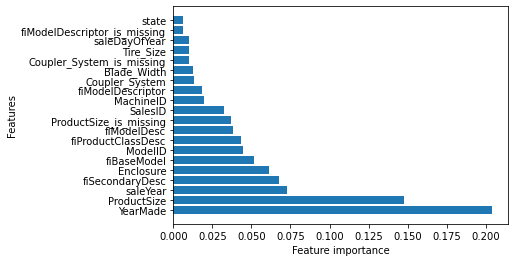

In [35]:
plot_features(X_train.columns, ideal_model.feature_importances_, 20)